# Capstone Project: EDA
### Requirements:
1. Create an exploratory data analysis notebook.
2. Perform statistical analysis, along with any visualizations.
3. Determine how to handle sampling or missing values.
4. Clearly identify shortcomings, assumptions, and next steps.

### The Data: 
- There are 3 separate datasets (A: demographics, B: transactions, and C: sessions)
- Specific to the year 2019 (will compare predictions with 2020)
- Data dictionary is in directory (see ComScore Data Dicitionary.pdf)
    - Citation: Wharton Research Data Services. "WRDS" wrds.wharton.upenn.edu, accessed 2021-09-27.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
from datetime import timedelta
from impyute.imputation.cs import mice
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()
%matplotlib inline

In [2]:
print(pd.__version__)
print(np.__version__)
import matplotlib
print(matplotlib.__version__)
print(sns.__version__)

1.2.4
1.20.1
3.3.4
0.11.1


## A: Demographics
- Call Google Sheets API to get data

In [3]:
from googleapiclient.discovery import build
from google.oauth2 import service_account

#Allow access (credentials)
SERVICE_ACCOUNT_FILE = 'client_secrets.json'
#This is what we need access to 
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

creds = None
creds = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)

#d/19m3Fqxc1RXpEFl2L8WyH-P9Ii__tAMREyNkhm9jq7iM
#https://docs.google.com/spreadsheets/d/19m3Fqxc1RXpEFl2L8WyH-P9Ii__tAMREyNkhm9jq7iM/edit#gid=715990799
# The ID of a sample spreadsheet
SAMPLE_SPREADSHEET_ID = '19m3Fqxc1RXpEFl2L8WyH-P9Ii__tAMREyNkhm9jq7iM'
service = build('sheets', 'v4', credentials=creds)

#1G0HYhvMKSLztaXhwS5WcE87kqK0BSlx3QwF-4bIdhpE
# Call the Sheets API
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range='demo2019!A1:K167952').execute()
values = result.get('values', [])

In [4]:
#Convert demographics list into df
demo2019 = pd.DataFrame(values)
#Properly assign columns 
demo2019.columns = demo2019[:1].values[0]
demo2019.drop([0], inplace=True)
#Reset index 
demo2019.set_index('machine_id', inplace=True)
#Drop connection speed column 
demo2019.drop(['connection_speed'], axis=1, inplace=True)
demo2019.head()

,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,country_of_origin,zip_code
machine_id,,,,,,,,,
89948345,99,3,1,10,13,0,2,0,70503
93919854,99,3,4,3,11,1,2,0,74726
94485706,5,99,4,11,17,1,2,1,99999
111304835,99,1,2,5,11,1,5,1,None
117807892,99,3,2,6,11,1,5,0,70127


In [5]:
print(demo2019.shape) #139,069 rows, 9 columns (not including index)

#Check data types 
print(demo2019.dtypes) #Note that all columns are objects...need to convert to integer
#Note that even though all of these columns are integers, 6 columns are  categorical, 2 are binary\
#and 1 is a true integer. 

demo2019 = demo2019.apply(pd.to_numeric)

(139069, 9)
hoh_most_education    object
census_region         object
household_size        object
hoh_oldest_age        object
household_income      object
children              object
racial_background     object
country_of_origin     object
zip_code              object
dtype: object


In [6]:
#Evaluating nulls
#Multiple columns have 'unknown' values of 99 so I want to know what is the frequency of those values.
    #Nulls are most significant in hoh_most_education column (73%) --> Do not use as feature 
for cols in demo2019.columns[0:]:
   print(pd.DataFrame(demo2019[cols].value_counts(normalize=True)))
    
demo2019.isnull().sum()  #zip code column is the only col with nulls (3,288 nulls) 

#How should we treat nulls? Impute nulls: change all NAs to 99999 (dummy entry) 
demo2019.zip_code.fillna('99999', inplace=True)
len(demo2019[demo2019['zip_code'] == 99999.0]) #44 dummy records 

    hoh_most_education
99            0.590268
3             0.142138
2             0.134444
4             0.100216
1             0.017071
5             0.015863
    census_region
3        0.416017
4        0.215238
2        0.196248
1        0.172181
99       0.000316
    household_size
2         0.372650
1         0.188626
3         0.171433
5         0.143591
4         0.120588
99        0.003114
    hoh_oldest_age
8         0.189208
7         0.150558
11        0.138083
9         0.108047
6         0.089732
5         0.069009
10        0.067175
4         0.059273
3         0.054685
2         0.040217
1         0.034012
    household_income
11          0.305762
12          0.185448
13          0.145805
16          0.102654
15          0.087920
18          0.080413
14          0.063127
17          0.028871
   children
1  0.511063
0  0.488937
     racial_background
 1            0.542047
 2            0.218338
 5            0.184369
 3            0.055152
-88           0.000093
   coun

44

,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,country_of_origin
hoh_most_education,1.000000,0.013968,0.005995,-0.260597,-0.120016,-0.208636,0.169271,-0.047259
census_region,0.013968,1.000000,0.009507,-0.018906,-0.006986,-0.004598,0.013469,0.036951
household_size,0.005995,0.009507,1.000000,-0.004352,0.011641,0.161070,-0.006531,0.009534
hoh_oldest_age,-0.260597,-0.018906,-0.004352,1.000000,0.072670,-0.113786,-0.170730,-0.060076
household_income,-0.120016,-0.006986,0.011641,0.072670,1.000000,0.066028,-0.009004,-0.051891
children,-0.208636,-0.004598,0.161070,-0.113786,0.066028,1.000000,0.110799,0.054530
racial_background,0.169271,0.013469,-0.006531,-0.170730,-0.009004,0.110799,1.000000,0.203301
country_of_origin,-0.047259,0.036951,0.009534,-0.060076,-0.051891,0.054530,0.203301,1.000000


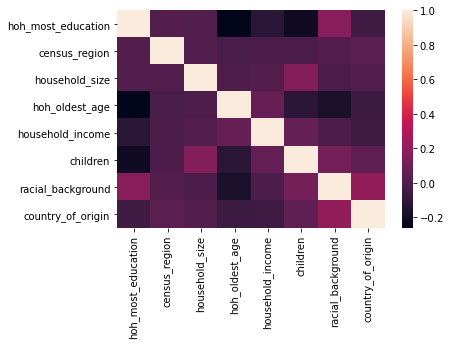

In [7]:
sns.heatmap(demo2019.corr()) 
demo2019.corr()
#Education and racial background have the strongest positive correlation (intuitively makes sense.#
#The strongest negative correlation is b/t education region and age.

In [8]:
demo2019.hoh_most_education.value_counts()

99    82088
3     19767
2     18697
4     13937
1      2374
5      2206
Name: hoh_most_education, dtype: int64

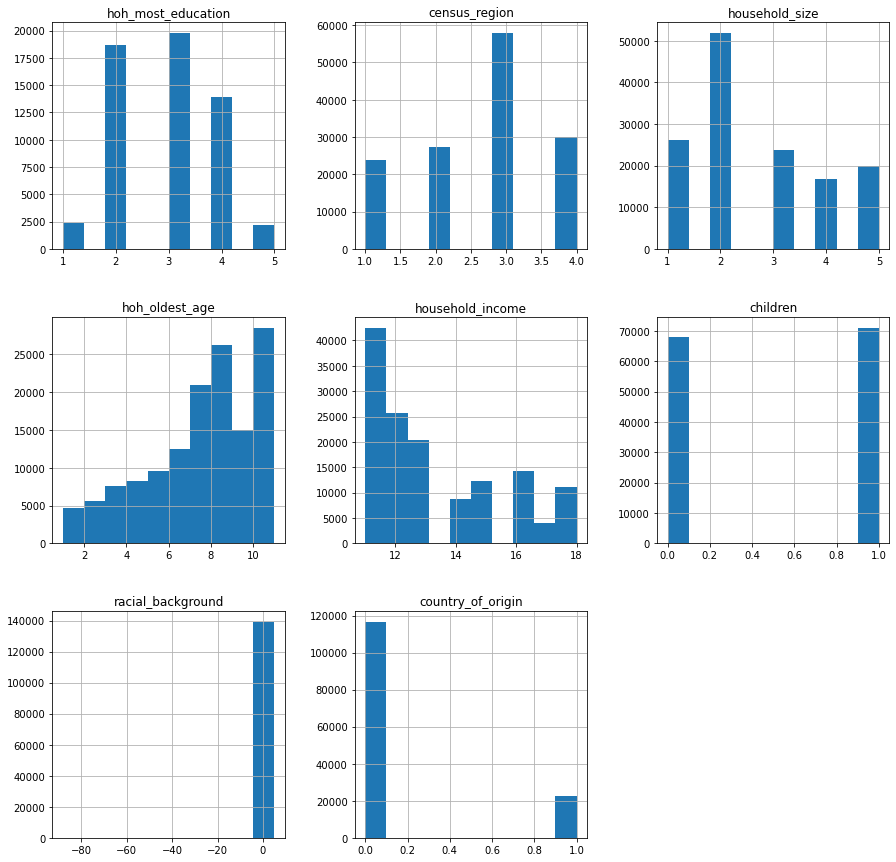

In [9]:
#Dummy entries may be skewing view, let's get rid of them and re-visualize 
cols = ['hoh_most_education', 'census_region', 'household_size',
       'hoh_oldest_age', 'household_income', 'children', 'racial_background', 'country_of_origin']
demo2019[demo2019[cols]<99].hist(figsize=(15,15));

In [10]:
#Grouping binary columns 
demo2019.groupby(['children', 'country_of_origin']).count() 
#Data looks pretty balanced, except racial background and country origin

hoh_most_education  census_region  household_size  \
children country_of_origin                                                      
0        0                               58351          58351           58351   
         1                                9645           9645            9645   
1        0                               58132          58132           58132   
         1                               12941          12941           12941   

                            hoh_oldest_age  household_income  \
children country_of_origin                                     
0        0                           58351             58351   
         1                            9645              9645   
1        0                           58132             58132   
         1                           12941             12941   

                            racial_background  zip_code  
children country_of_origin                               
0        0                              58351     58351  
         1                               9645      9645  
1        0                              58132     58132  
         1                              12941     12941

### Now let's do some cool stuff with zip codes!

In [11]:
#Need to convert zipcode column to string 
demo2019['zip_code'] = demo2019['zip_code'].apply(str)
#Drop decimal 
demo2019['zip_code'] = pd.DataFrame(demo2019['zip_code'].str.split(pat='.', expand=True)[0])

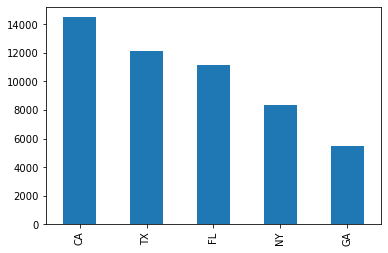

In [12]:
#Adding 2 geo columns based on zip code 
demo2019['city_name'] = demo2019['zip_code'].map(lambda x: search.by_zipcode(x).major_city)
demo2019['state'] = demo2019['zip_code'].map(lambda x: search.by_zipcode(x).state)
#Histogram of top 5 states 
demo2019['state'].value_counts().head(5).plot(kind="bar");

In [13]:
demo2019.tail()

,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,country_of_origin,zip_code,city_name,state
machine_id,,,,,,,,,,,
284912174,2,3,3,11,15,1,1,0,29532,Darlington,SC
284912175,99,3,5,8,11,0,2,0,70818,Baton Rouge,LA
284912202,5,4,1,11,15,0,1,0,99999,None,None
284912227,4,3,5,9,12,1,2,0,20716,Bowie,MD
284912239,99,1,4,11,11,0,1,0,99999,None,None


### What we learned from the demographics data:
- Majority of people in this dataset:
    - have an Associates degree
    - are from the South 
    - have a 2 person household size 
    - make less than $59,000
    - about 50% have children and the other 50% don't 
    - are Caucasian
    - are non-Hispanic 
- Top 5 states (in descending order): California, Texas, Florida, New York, Georgia.

## B: Transactions Data

In [14]:
trans2019 = pd.read_csv('trans2019.csv')
trans2019.index = trans2019.machine_id.astype(str)
trans2019.drop('machine_id', axis=1, inplace=True)
print(trans2019.shape) #581,088 rows, 10 cols 

#Drop domain ID column bc we already have domain name 
trans2019.drop(['domain_id'], axis=1, inplace=True)
trans2019.dtypes #We've got 2 integers, 3 objects, and 3 floats

(581088, 10)


site_session_id       int64
prod_category_id      int64
prod_name            object
prod_qty            float64
prod_totprice       float64
basket_tot          float64
event_date           object
event_time           object
domain_name          object
dtype: object

In [15]:
#Transform event_date and event_time columns 
trans2019['event_date'] = pd.to_datetime(trans2019.event_date)
trans2019['month'] = trans2019.event_date.dt.month
trans2019['day'] = trans2019.event_date.dt.day
df = pd.DataFrame(trans2019.event_time.str.split(pat=':', expand=True))
df.rename(columns ={0:'hour', 1:'minute', 2:'second'}, inplace=True)
trans2019['hour'] = df['hour'].astype(int)
trans2019['minute'] = df['minute'].astype(int)
trans2019['second'] = df['second'].astype(int)

#Drop if basket total = 0 
trans2019 = trans2019[trans2019['basket_tot'] >0]
trans2019.head()
print(trans2019.isnull().sum())

site_session_id         0
prod_category_id        0
prod_name            3770
prod_qty                0
prod_totprice       34822
basket_tot              0
event_date              0
event_time              0
domain_name             0
month                   0
day                     0
hour                    0
minute                  0
second                  0
dtype: int64


In [16]:
#Evaluating nulls (prod_name and prod_totprice)
for cols in trans2019.columns[0:]:
   print(pd.DataFrame(trans2019[cols].value_counts(normalize=True)))
#20% of site_session_id are nulls disguised as 0s
#prod_category_id has 15% null values 
    
#Imputing prod_name nulls
trans2019.prod_name.fillna('Unknown', inplace=True)

#Will impute nulls in 'prod_totprice' col with 
trans2019.fillna(value={'prod_totprice': trans2019['prod_totprice'].mean() }, inplace=True)

                     site_session_id
0                           0.204134
8900684409014775921         0.000174
2328991449883855675         0.000161
6865195613475022844         0.000129
3864912211362590227         0.000121
...                              ...
1387664992824660891         0.000002
2954118158484952112         0.000002
1574616165688331229         0.000002
7314324429906879735         0.000002
4607214019686351270         0.000002

[224481 rows x 1 columns]
            prod_category_id
999                 0.153603
1001001014          0.067083
7008024233          0.064053
7008023051          0.044138
3004010078          0.037567
...                      ...
6007022222          0.000002
2003005059          0.000002
7009031112          0.000002
7008023050          0.000002
2003005067          0.000002

[245 rows x 1 columns]
                                                    prod_name
Pizza                                                0.017356
Not Found                        

In [17]:
#Cleaning up product category data dictionary 
dff = pd.read_csv('product_category_lookup.csv', header=None)

#Rename columns 
colnames = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
dff.columns = colnames

#Write function to append text 
def convert(num):
    return(dff.iloc[:, num].astype(str).values + ' (' + dff.iloc[:, 1].astype(str).values + ')')
    
#Assign new col values to old col values
for i in list(range(2,10,2)):
    for j in ['aaa','bbb','ccc','ddd']:
        dff[j] = convert(i)
        
#Drop nonsense cols & reorder
dff = dff[['A','aaa', 'D', 'bbb', 'F', 'ccc', 'H', 'ddd']]

#Return only 2 columns; ID and name 
a = dff.iloc[:,0:2].rename(columns={'A':'ID', 'aaa':'Name'})
b = dff.iloc[:,2:4].rename(columns={'D':'ID', 'bbb':'Name'})
c = dff.iloc[:,4:6].rename(columns={'F':'ID', 'ccc':'Name'})
d = dff.iloc[:,6:8].rename(columns={'H':'ID', 'ddd':'Name'})

prod_cat_dict = pd.concat([a,b,c,d], ignore_index=True)

#Map values in dictionary to trans2019 df
mapping = dict(prod_cat_dict[['ID', 'Name']].values)
trans2019['prod_cat_name'] = trans2019.prod_category_id.map(mapping)
trans2019.prod_cat_name.value_counts().head(15)

nan (NON-TRAVEL)                        68451
WOMEN (NON-TRAVEL)                      35905
FOOD DELIVERY (NON-TRAVEL)              34283
PERSONAL CARE (NON-TRAVEL)              23624
ELECTRONICS ACCESSORIES (NON-TRAVEL)    20107
WEDDING SHOP (NON-TRAVEL)               14820
AIR TRAVEL (TRAVEL)                     13084
KITCHEN & DINING (NON-TRAVEL)           12352
AUTO PARTS (NON-TRAVEL)                 12351
HOTEL RESERVATIONS (TRAVEL)             10916
MEN (NON-TRAVEL)                        10837
TOOLS (NON-TRAVEL)                      10466
FASHION JEWELRY (NON-TRAVEL)             7753
CAR RENTAL (TRAVEL)                      7608
SHOES (NON-TRAVEL)                       7200
Name: prod_cat_name, dtype: int64

In [18]:
trans2019[trans2019['domain_name'] != 'amazon.com']['domain_name'].value_counts(normalize=True)

ebay.com                 0.149932
walmart.com              0.096129
dominos.com              0.073091
kohls.com                0.031758
papajohns.com            0.029140
                           ...   
tigerdirect.com          0.000077
midnightvelvet.com       0.000053
payless.com              0.000050
dollarshaveclub.com      0.000010
sierratradingpost.com    0.000007
Name: domain_name, Length: 177, dtype: float64

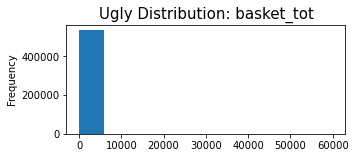

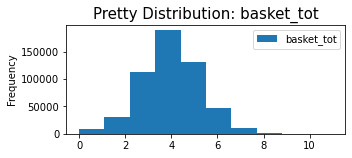

/Users/tolulopeadebayo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


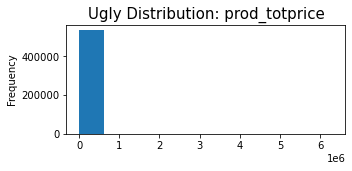

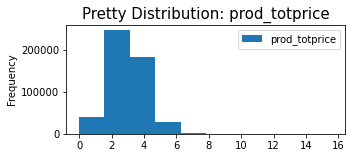

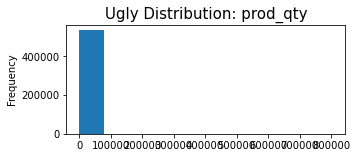

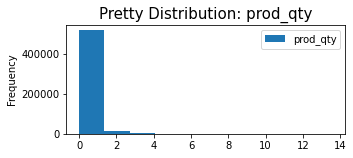

In [19]:
#Let's look at some distributions 
numerical_cols = ['basket_tot', 'prod_totprice', 'prod_qty']

#Need to tranform to natural log bc distribution is wide
for i in numerical_cols:
    trans2019[i].plot(kind='hist', figsize=(5,2)).set_title('Ugly Distribution: '+ str(i), fontsize=15);
    df = pd.DataFrame(np.log(trans2019[i]))
    df[df[i]>=0].plot(kind='hist', figsize=(5,2)).set_title('Pretty Distribution: '+ str(i), fontsize=15);
    plt.show()

In [20]:
#Good news: Basket total (basket_tot) and product price (prod_totprice) almost looks like a normal distribution...\
#Bad news: Product quantity(prod_qty) has an extreme right tail...so the mean > mode
#Poitive kurtosis?
trans2019.prod_qty.mean() > statistics.mode(trans2019['prod_qty'])

True

In [21]:
#Top domains/websites 
trans2019.domain_name.value_counts().head(10)
trans2019.domain_name.value_counts(normalize=True).head()

amazon.com     0.439628
ebay.com       0.084018
walmart.com    0.053868
dominos.com    0.040958
kohls.com      0.017796
Name: domain_name, dtype: float64

In [22]:
#Site_session_id is another unique ID but unique in conjunction w event date and time 

#Show site session id grouped by time and date 
trans2019.groupby(['site_session_id', 'event_date', 'event_time']).max('basket_tot').tail(5)

prod_category_id  prod_qty  \
site_session_id     event_date event_time                               
9223272736257504539 2019-05-14 15:18:17          1001001014       1.0   
9223280560014554383 2019-01-07 3:23:11           1001001014       1.0   
9223334383795485381 2019-01-30 19:29:41          7008024233       1.0   
9223336846825662691 2019-05-03 16:04:06          7008025108       1.0   
                               17:58:43          7008023051       1.0   

                                           prod_totprice  basket_tot  month  \
site_session_id     event_date event_time                                     
9223272736257504539 2019-05-14 15:18:17            16.99        9.67      5   
9223280560014554383 2019-01-07 3:23:11            149.99      163.49      1   
9223334383795485381 2019-01-30 19:29:41             8.94       37.30      1   
9223336846825662691 2019-05-03 16:04:06             3.99        3.99      5   
                               17:58:43             4.50        4.50      5   

                                           day  hour  minute  second  
site_session_id     event_date event_time                             
9223272736257504539 2019-05-14 15:18:17     14    15      18      17  
9223280560014554383 2019-01-07 3:23:11       7     3      23      11  
9223334383795485381 2019-01-30 19:29:41     30    19      29      41  
9223336846825662691 2019-05-03 16:04:06      3    16       4       6  
                               17:58:43      3    17      58      43

In [23]:
#Top 15 items are as follows...Not surprised that food is top 6 haha!
pd.DataFrame(trans2019.prod_name.value_counts()).head(10) 

,prod_name
Pizza,9224
Unknown,3770
Not Found,3678
Sides,2816
Bread,2176
Wings,2016
Drinks,1800
roundtrip Flight,1580
Dessert,1572
"Prints, 4x6",1300


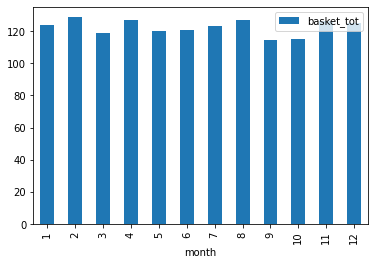

In [24]:
#Let's plot avg basket total by month 
trans2019[['month','basket_tot']].groupby('month').mean('basket_tot').plot(kind='bar');

<AxesSubplot:xlabel='event_date'>

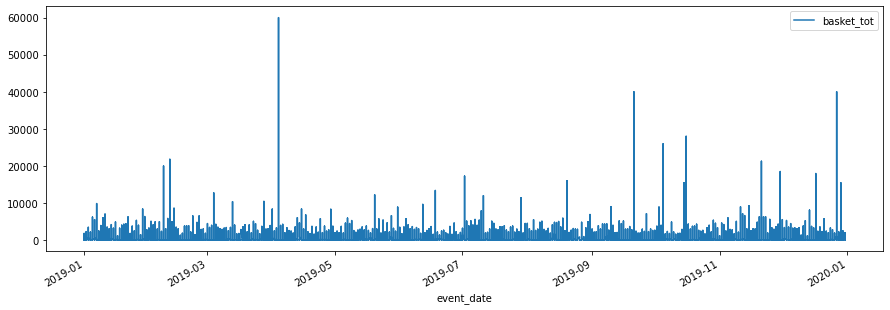

In [43]:
#Let's plot avg basket total by month 
trans2019.plot(kind='line', figsize=(15,5), x='event_date', y='basket_tot')

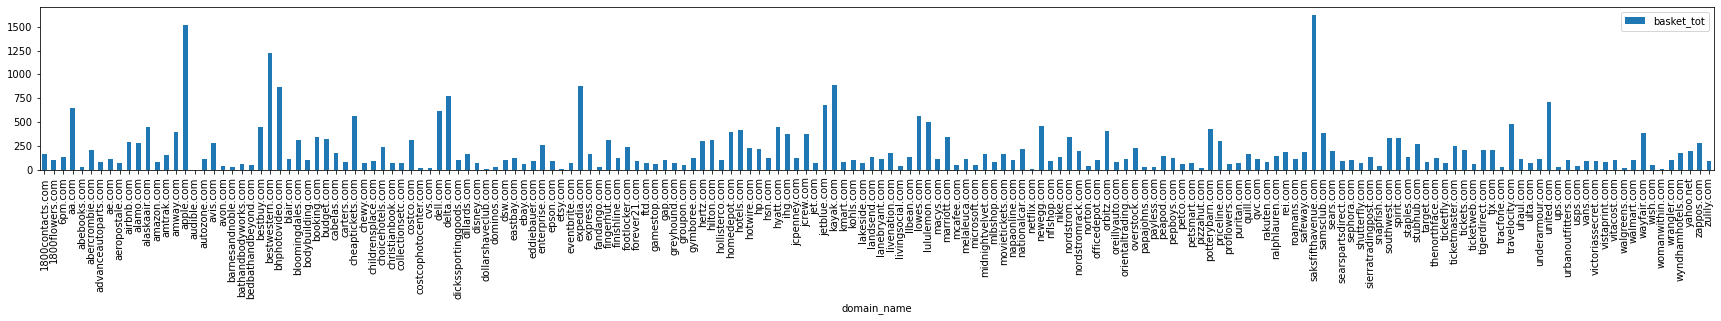

In [26]:
#Domain and basket total
trans2019[['domain_name', 'basket_tot']].groupby('domain_name').mean('prod_totprice').plot(kind='bar', figsize=(30,3));

### What we learned from the transactions data:
- Top 5 product categories: Women, Food Delivery, Personal Care, Electronics Accessories, Fashion Jewelry
- Top 10 websites: amazon.com, ebay.com, walmart.com, dominos.com, target.com, kohls.com, samsclub.com, etsy.com, papajohns.com, chewy.com
- Amazon accounts for almost 44% of all transactions 
- Top 5 product items: Pizza, Sides, Bread, Wings, Drinks	

## C: Sessions Data

In [27]:
sess2019 = pd.read_csv('sessions2019.csv')
print(sess2019.shape) #1,556,757 rows, 11 cols 
#sess2019.set_index('machine_id', inplace=True)
sess2019.head()

(224480, 11)


/Users/tolulopeadebayo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,site_session_id,machine_id,user_session_id,domain_id,ref_domain__name,pages_viewed,duration,event_date,event_time,tran_flg,domain_name
0,1000017909239914348,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000406262467311679,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000578923578008850,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001446498515399418,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001625075236765557,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#Drop some nonsense columns 
sess2019.drop(['user_session_id','domain_id','domain_name','tran_flg'], axis=1, inplace=True)
pd.DataFrame(sess2019).head()

sess2019.isnull().sum()
#Imputing nulls and drop rest 
sess2019['ref_domain__name'].fillna('Unknown', inplace=True)
sess2019 = sess2019[sess2019.notnull()]

#Convert data types
sess2019['event_date'] = pd.to_datetime(sess2019.event_date)

<AxesSubplot:xlabel='event_date'>

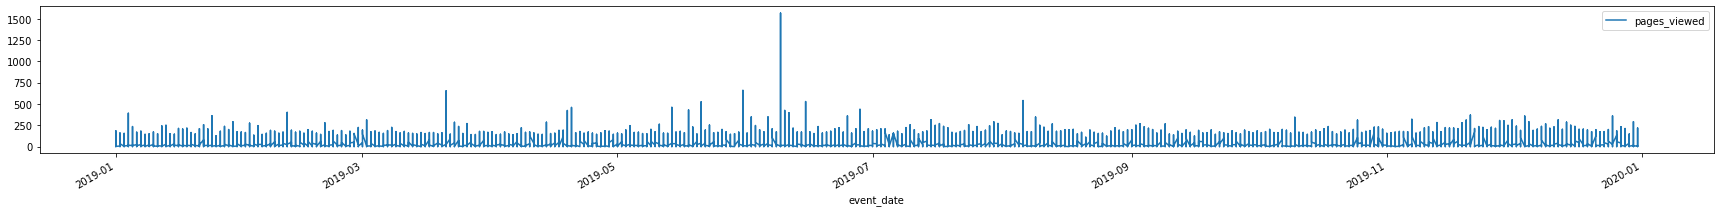

In [29]:
sess2019[['event_date', 'pages_viewed']].plot(x='event_date', y='pages_viewed', figsize=(30,3))

In [30]:
#df = pd.DataFrame(np.log(trans2019[i]))
 #   df[df[i]>=0].plot(kind='hist', figsize=(5,2)).set_title('Pretty Distribution: '+ str(i), fontsize=15);
  #  plt.show()

In [31]:
for cols in sess2019.columns[0:]:
   print(pd.DataFrame(sess2019[cols].value_counts(normalize=True)))

                     site_session_id
3112289038261360946         0.000004
3468703878747476469         0.000004
1108817489599035856         0.000004
8546817848601738021         0.000004
1457649843507509349         0.000004
...                              ...
5148814262685460366         0.000004
1234835373336773215         0.000004
4226415110660847914         0.000004
548326474556196927          0.000004
1058287185961853025         0.000004

[224480 rows x 1 columns]
             machine_id
282139070.0    0.000826
283577174.0    0.000765
255384948.0    0.000760
260301264.0    0.000750
280689095.0    0.000740
...                 ...
250157133.0    0.000005
248858676.0    0.000005
268264665.0    0.000005
274899243.0    0.000005
279521442.0    0.000005

[35129 rows x 1 columns]
                         ref_domain__name
Unknown                          0.893171
amazon.com                       0.050013
ebay.com                         0.016848
google.com                       0.005145
paypa

<AxesSubplot:title={'center':'Average Pages Viewed, by Domain Name'}, xlabel='ref_domain__name'>

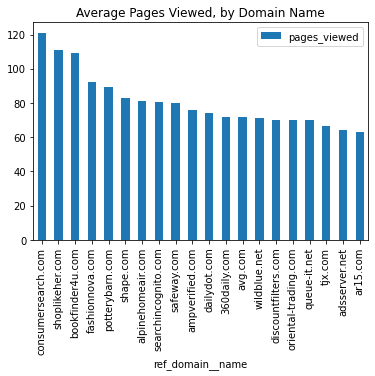

In [32]:
#Average Pages Viewed, by Domain Name
pd.DataFrame(sess2019.groupby(by='ref_domain__name').mean('pages_viewed').\
             sort_values(by='pages_viewed',ascending=False)['pages_viewed']).head(20)\
            .plot(kind='bar', title = 'Average Pages Viewed, by Domain Name')

<AxesSubplot:title={'center':'Max Duration, by Domain Name'}, xlabel='ref_domain__name'>

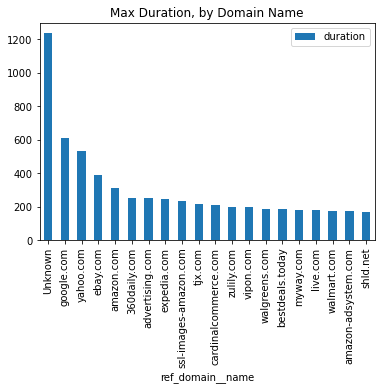

In [33]:
#Max Duration, by Domain Name
pd.DataFrame(sess2019.groupby(by='ref_domain__name').max('duration').\
             sort_values(by='duration',ascending=False)['duration']).head(20)\
            .plot(kind='bar', title = 'Max Duration, by Domain Name')

### What we learned from the sessions data:
- Pages viewed spiked sometime in June 
- Domains with highest avg pages viewed (top 3): consumersearch.com, shoplikeher.com, and bookfinder4u.com
- Domains with highest max duration (top 3): cgoogle.com, yahoo.com, and ebay.com

In [34]:
#Export all cleaned files 
demo2019.to_csv (r'demo2019_clean.csv', index = True, header=True)
trans2019.to_csv (r'trans2019_clean.csv', index = True, header=True)
sess2019.to_csv (r'sess2019_clean.csv', index = True, header=True)


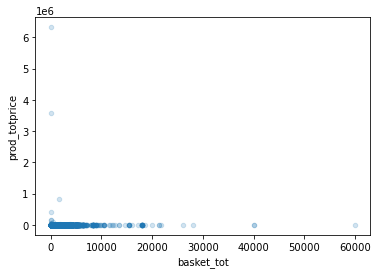

In [35]:
trans2019.plot(kind='scatter', x='basket_tot', y='prod_totprice', alpha=0.2);
# Seaborn scatterplot with regression line
#sns.lmplot(x='temp', y='total_rentals', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

In [36]:
#Get average basket totals for 2020
trans2020 = pd.read_csv('trans2020_clean.csv')
#trans2020.head()
pd.DataFrame(trans2020[trans2020['domain_name'].isin(['amazon.com','jetblue.com', 'dominos.com']) == True].\
groupby('domain_name').mean('basket_tot')['basket_tot'])

,basket_tot
domain_name,
amazon.com,90.907363
dominos.com,31.625123
jetblue.com,468.299219


In [37]:
#Get number of customers 
trans2020[trans2020['domain_name'].isin(['amazon.com','jetblue.com', 'dominos.com'])].\
groupby('domain_name').nunique()['machine_id']

domain_name
amazon.com     37130
dominos.com     4232
jetblue.com      523
Name: machine_id, dtype: int64

In [38]:
#Get number of products 
trans2020[trans2020['domain_name'].isin(['amazon.com','jetblue.com', 'dominos.com'])].\
groupby('domain_name').sum('prod_qty')['prod_qty']

domain_name
amazon.com     496258.0
dominos.com     33964.0
jetblue.com      3346.0
Name: prod_qty, dtype: float64

In [44]:
pd.DataFrame(trans2019[trans2019['domain_name'].isin(['amazon.com','jetblue.com', 'dominos.com']) == True].\
groupby('domain_name').mean('basket_tot')['basket_tot'])

,basket_tot
domain_name,
amazon.com,83.804189
dominos.com,29.427780
jetblue.com,681.150114


In [48]:
pd.DataFrame(trans2019[trans2019['domain_name'].isin(['amazon.com','jetblue.com', 'dominos.com']) == True].\
groupby('domain_name').sum('basket_tot')['basket_tot'])

,basket_tot
domain_name,
amazon.com,1.971938e+07
dominos.com,6.451158e+05
jetblue.com,2.279809e+06
